# Packages

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import math
from nltk import tokenize


C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data handling

## Load data

In [2]:
#LOAD DATA
print("Loading data...")
train = pd.read_table("../../dat/train.tsv")
test = pd.read_table("../../dat/test.tsv")
print('Data loaded')
print(train.shape)
print(test.shape)


Loading data...
Data loaded
(1482535, 8)
(693359, 7)


## Handle missing values

In [3]:
#HANDLE MISSING VALUES
print("Handling missing values...")
def handle_missing(dataset):
    dataset.category_name.fillna(value="missing", inplace=True)
    dataset.brand_name.fillna(value="missing", inplace=True)
    dataset.item_description.fillna(value="missing", inplace=True)
    return (dataset)

train = handle_missing(train)
test = handle_missing(test)
print(train.shape)
print(test.shape)

Handling missing values...
(1482535, 8)
(693359, 7)


In [4]:
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


## Handle categorial features

In [5]:
#PROCESS CATEGORICAL DATA
print("Handling categorical variables...")
le = LabelEncoder()

le.fit(np.hstack([train.category_name, test.category_name]))
train.category_name = le.transform(train.category_name)
test.category_name = le.transform(test.category_name)

le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)

le.fit(np.hstack([train.name, test.name]))
train.name = le.transform(train.name)
test.name = le.transform(test.name)
del le

train.head(3)

Handling categorical variables...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,916335,3,829,5265,10.0,1,No description yet
1,1,1292428,3,86,3889,52.0,0,This keyboard is in great condition and works ...
2,2,131013,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...


## Target formatting

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000281945C4BE0>]], dtype=object)

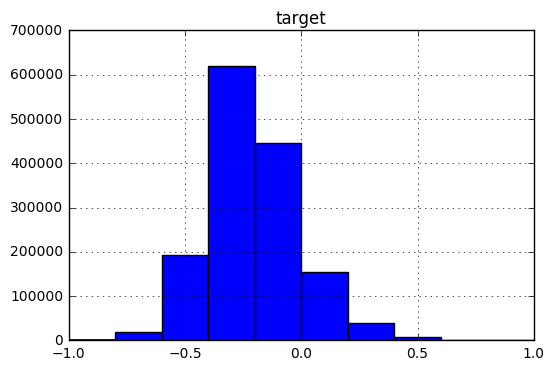

In [6]:
#SCALE target variable
train["target"] = np.log(train.price+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
train["target"] = target_scaler.fit_transform(train.target.reshape(-1,1))
pd.DataFrame(train.target).hist()

## Train/Val split

In [7]:
#EXTRACT DEVELOPTMENT TEST
dtrain, dvalid = train_test_split(train, random_state=123, train_size=0.99)
print(dtrain.shape)
print(dvalid.shape)

(1467709, 9)
(14826, 9)


In [16]:
#Get selected data

def get_features(dataset):
    #X = pd.concat([dataset.name, dataset.brand_name, dataset.category_name, dataset.item_condition_id, dataset.shipping], axis=1)
    X = pd.concat([dataset.brand_name, dataset.category_name, dataset.item_condition_id, dataset.shipping], axis=1)
    X = np.array(X)
    return X

X_train = get_features(dtrain)
X_valid = get_features(dvalid)
X_test = get_features(test)

# Model

In [18]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Fit regression model
model = DecisionTreeRegressor(splitter='random')




In [10]:

print(X_train.shape)
print(np.array(dtrain[["target"]]).shape)

(1467709, 5)
(1467709, 1)


# Train/fit

In [21]:
#FITTING THE MODEL

model.fit(X_train, np.array(dtrain[["target"]]))
#model.fit(X_train, dtrain.target)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='random')

## KFold (TODO)

# Evaulate

In [12]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
#Source: https://www.kaggle.com/marknagelberg/rmsle-function

In [22]:
#EVLUEATE THE MODEL ON DEV TEST: What is it doing?
val_preds = model.predict(X_valid)
val_preds = np.reshape(val_preds, [len(val_preds), 1])
#print(np.reshape(val_preds, [len(val_preds), 1]).shape)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds)+1

#mean_absolute_error, mean_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on dev test: "+str(v_rmsle))

 RMSLE error on dev test: 0.5796173413106781


# Submit

In [14]:
#CREATE PREDICTIONS
preds = model.predict(X_test)
preds = np.reshape(preds, [len(preds), 1])
preds = target_scaler.inverse_transform(preds)
preds = np.exp(preds)-1

submission = test[["test_id"]]
submission["price"] = preds

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


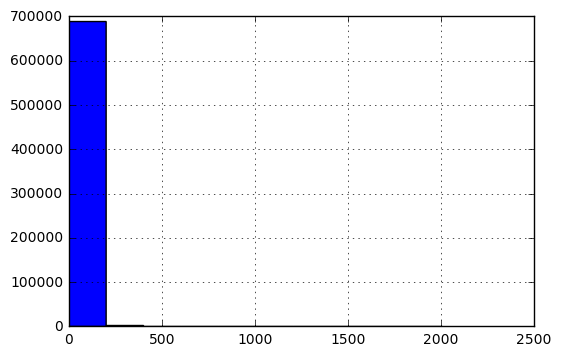

In [15]:
submission.to_csv("./myDTsubmission.csv", index=False)
submission.price.hist()